<a href="https://colab.research.google.com/github/FinOloughlin/CITS4403-Black-Death/blob/trying-to-make-continuous/Copy_of_Copy_of_Black_Death.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np

In [8]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

In [9]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

In [10]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

### !! Mesa documentation: https://mesa.readthedocs.io/stable/

In [11]:
!pip install mesa

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.space import ContinuousSpace
from mesa.datacollection import DataCollector


# Black Death

In [18]:
class PlagueAgent(Agent):
  """
  An agent representing a person in a simulated bubonic plague scenario.

  Attributes:
    unique_id: Unique identifier for the agent.
    model: Reference to the model in which the agent participates.
    health_status: Current health status of the agent ("Susceptible", "Infected", "Recovered", "Dead").
    age: Age of the agent, randomly assigned between 1 and 80.
    steps_infected: Number of steps the agent has been infected.
    recovered: Whether the agent has recovered from the infection.
    dead: Whether the agent has died from the infection.
    seeking_treatment: Whether the agent is seeking medical treatment.
  """
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.health_status = "Susceptible"
    self.age = self.random.randrange(1,80)
    self.steps_infected = 0
    self.recovered = False
    self.dead = False
    self.seeking_treatment = False

  def step(self):
    self.try_random_infection()

    # If infected update the number of days infected
    if self.health_status == "Infected":
      want_to_cure = 0.6
      self.steps_infected += 1
      # After 4 days, check if the agent recovers or dies
      if self.steps_infected >= 6 and self.steps_infected % 3 == 0:
        self.check_recovery_or_death()

      # If agent is infected, they will start seeking treatment
      if self.random.random() < want_to_cure:
        self.seeking_treatment = True

      if self.seeking_treatment:
        self.move_to_doctor() # Move towards doctor's office for treatment

      if self.is_near_doctor_office():
        self.try_to_get_cured()

      # Spread the disease to nearby agents
      self.spread_disease()

    # Move the agent to a random neighbouring cell
    self.move()

  def move_to_doctor(self):
    """
    Move the agent towards the nearest doctor's office.

    Calculates the direction to the nearest doctor's office and updates the agent's position accordingly.
    """
    nearest_office = min(self.model.doctor_offices, key=lambda office: self.distance(office[0]))

    direction = (nearest_office[0][0] - self.pos[0], nearest_office[0][1] - self.pos[1])

    distance_to_office = np.sqrt(direction[0] ** 2 + direction[1] ** 2)

    if distance_to_office > 0:
      direction = (direction[0] / distance_to_office, direction[1] / distance_to_office)
      step_size = 1.0
      self.pos = (self.pos[0] + direction[0] * step_size, self.pos[1] + direction[1] * step_size)

  def is_near_doctor_office(self, threshold=1.0):
    """
    Check if the agent is near a doctor office.

    Parameters:
    - threshold: The distance within which the agent is considered 'near' a doctor's office.

    Returns:
    - True if the agent is near a doctor's office, False otherwise.
    """
    for office in self.model.doctor_offices:
      distance_to_office = self.distance(office[0])
      if distance_to_office <= threshold:
        return True
    return False


  def try_to_get_cured(self):
    """
    Try to get cured from the disease, when visiting a doctor's office.

    Recovery change depends on the treament strategy and the agent's age.
    The method uses the treatment strategy associated with the nearest doctor's office to determine
    recovery probability.
    """
    nearest_office = min(self.model.doctor_offices, key=lambda office: self.distance(office[0]))

    treatment_strategy = nearest_office[1]

    if treatment_strategy == "Bloodletting":
        recovery_chance = 0.1
    elif treatment_strategy == "Leaches":
      if 10 <= self.age <= 30:
        recovery_chance = 0.15
      else:
        recovery_chance = 0.1
    elif treatment_strategy == "Herbal_Remedies":
      if 10 <= self.age <= 30:
        recovery_chance = 0.2
      else:
        recovery_chance = 0.1
    elif treatment_strategy == "Quarantine":
      if 10 <= self.age <= 30:
        recovery_chance = 0.3
      else:
        recovery_chance = 0.2


    if self.random.random() < recovery_chance:
      self.recovered = True
      self.health_status = "Recovered"
      self.seeking_treatment = False
      self.model.treatment_data[treatment_strategy]['recovered'] += 1
    else:
      self.dead = True
      self.health_status = "Dead"
      self.model.treatment_data[treatment_strategy]['died'] += 1

  def distance(self, target):
    """
    Calculate the Euclidean distance between the agent's position and the target.

    Parameters:
    - target: Tuple representing the (x, y) coordinates of the target.

    Returns:
    - Distance between the agent's position and the target.
    - Infinity if invalid locations.
    """
    if self.pos is not None and target is not None:
      x1, y1 = self.pos
      x2, y2 = target
      return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    return float('inf')

  def spread_disease(self):
    """
    Infect neighboring agents within a certain radius with a 10% chance.
    """
    infection_chance = 0.1
    infection_radius = 1.0

    for agent in self.model.schedule.agents:
      if agent != self and agent.health_status == "Susceptible":
        distance_to_agent = self.distance(agent.pos)
        if distance_to_agent <= infection_radius:
          if self.random.random() < infection_chance:
            agent.health_status = "Infected"

  def try_random_infection(self):
    """
    Randomly infect a neighboring agent with a 5% chance, if the agent is susceptible.
    """
    chance = 0.05
    if self.health_status == "Susceptible" and self.random.random() < chance:
      self.health_status = "Infected"

  def check_recovery_or_death(self):
    """
    Check if the agent recovers or dies after being infected.
    The chances of recovery and death depend on the agent's age.
    """

    # Set recovery chances based on age
    if self.age < 10:
      recovery_chance = 0.25
    elif 10 <= self.age <= 30:
      recovery_chance = 0.4
    elif 30 <= self.age <= 50:
      recovery_chance = 0.3
    else:
      recovery_chance = 0.2

    # Set death chances based on age
    if self.age < 10:
      death_chance = 0.55
    elif 10 <= self.age <= 30:
      death_chance = 0.4
    elif 30 <= self.age <= 50:
      death_chance = 0.5
    else:
      death_chance = 0.8

    if not self.recovered and not self.dead:
      if self.random.random() < recovery_chance:
        self.recovered = True
        self.health_status = "Recovered"

    if not self.recovered and not self.dead:
      if self.random.random() < death_chance:
        self.dead = True
        self.health_status = "Dead"
        if self.seeking_treatment:
          nearest_office = min(self.model.doctor_offices, key=lambda office: self.distance(office[0]))
          treatment_strategy = nearest_office[1]
          self.model.treatment_data[treatment_strategy]['died'] += 1

  def move(self):
      """
      Move the agent to a new position randomly within a defined step size if the agent is not dead.
      """
      if self.health_status == "Dead":
          return

      step_size = 0.8

      # Generate a random direction
      angle = self.random.uniform(0, 2 * np.pi)
      dx = step_size * np.cos(angle)
      dy = step_size * np.sin(angle)

      new_x = self.pos[0] + dx
      new_y = self.pos[1] + dy

      # Ensure the new position is within the defined space
      new_x = max(0 + step_size, min(new_x, self.model.width - step_size))
      new_y = max(0 + step_size, min(new_y, self.model.height - step_size))

      self.model.space.move_agent(self, (new_x, new_y))

class PlagueModel(Model):
  """
  The model class that manages the simulation, grid and schedule of agents.

  Attributes:
    num_agents: Number of agents in the simulation.
    height: Height of the grid.
    width: Width of the grid.
    grid: A MultiGrid object to represent the grid of simulation.
    schedule: A schedule to manage when each agent's step function is called.
    doctor_offices: A list of tuples representing the positions of doctor offices.
  """
  def __init__(self, width, height, num_agents, num_doctors):
    super().__init__()
    self.num_agents = num_agents
    self.height = height
    self.width = width
    self.space = ContinuousSpace(width,height, torus=True)
    self.schedule = RandomActivation(self)

    # Create agents and doctor's offices
    self.create_agents()
    self.doctor_offices = self.create_doctor_office(num_doctors)

    # Data collection attributes
    self.day = 0
    self.health_status_data = []
    self.treatment_data = {treatment: {'recovered': 0, 'died': 0} for treatment in ["Bloodletting", "Leaches", "Herbal_Remedies", "Quarantine"]}
    self.age_outcome_data = []

    # Create agents and doctor's offices
    self.create_agents()
    self.doctor_offices = self.create_doctor_office(num_doctors)

  def create_agents(self):
    """
    Create all agents and place them in continuous space, with clustering logic to simulate housing.
    """
    max_neighbours = 2
    max_attempts = 5  # Limit the number of attempts to place an agent
    for i in range(self.num_agents):
      placed = False
      attempts = 0
      while not placed and attempts < max_attempts:
        if i == 0:
          # Place the first agent at a random location within the space
          x = self.random.uniform(0, self.width)
          y = self.random.uniform(0, self.height)
        else:
          # Try placing near an existing agent
          existing_agent = self.random.choice(self.schedule.agents)
          x, y = existing_agent.pos  # Get position of an existing agent

          # Randomize the placement around the existing agent
          x += self.random.uniform(-1, 1)  # Adjust by a small random value
          y += self.random.uniform(-1, 1)  # Adjust by a small random value

          # Ensure the new position is within the space boundaries
          x = max(0, min(self.width, x))
          y = max(0, min(self.height, y))

        # Check actual neighbors in continuous space (using the space method)
        if self.schedule.agents:
          neighbors = self.space.get_neighbors((x, y), radius=2.0)  # Adjust radius as needed
        else:
          neighbors = []

        if len(neighbors) <= max_neighbours:
          placed = True

        attempts += 1

      # If placed successfully, create and place the agent
      if placed:
        agent = PlagueAgent(i, self)
        self.space.place_agent(agent, (x, y))
        self.schedule.add(agent)
      else:
        # If unable to place within the attempt limit, place at a random location
        x = self.random.uniform(0, self.width)
        y = self.random.uniform(0, self.height)
        agent = PlagueAgent(i, self)
        self.space.place_agent(agent, (x, y))
        self.schedule.add(agent)


  def create_doctor_office(self, num_doctors):
    """
    Create doctor's offices at random locations on the grid.

    Parameters:
    - num_doctors: Number of doctor's offices to create.

    Returns:
    - A list of (x, y) tuples representing the positions of doctor offices.
    """
    doctor_offices = []
    treatments = ["Bloodletting", "Leaches", "Herbal_Remedies", "Quarantine"]
    for i in range(num_doctors):
      x = self.random.uniform(0, self.width)
      y = self.random.uniform(0, self.height)
      treatment = self.random.choice(treatments)
      doctor_offices.append(((x, y), treatment))
    return doctor_offices

  def step(self):
    """
    Execute one step for the agent in the simulation.

    The agent can become infected, seek treatment, recover or die based on its health status.
    It also spreads disease to neighbouring agents and moves randomly.
    """
    self.schedule.step()
    self.day += 1
    self.collect_data()

  def collect_data(self):
        susceptible = infected = recovered = dead = 0
        for agent in self.schedule.agents:
            if agent.health_status == "Susceptible":
                susceptible += 1
            elif agent.health_status == "Infected":
                infected += 1
            elif agent.health_status == "Recovered":
                recovered += 1
            elif agent.health_status == "Dead":
                dead += 1

        self.health_status_data.append({
            'day': self.day,
            'susceptible': susceptible,
            'infected': infected,
            'recovered': recovered,
            'dead': dead
        })

        # Collect age outcome data for newly recovered or dead agents
        for agent in self.schedule.agents:
            if agent.health_status in ["Recovered", "Dead"] and agent not in self.age_outcome_data:
                self.age_outcome_data.append({
                    'age': agent.age,
                    'outcome': agent.health_status
                })

  def get_treatment_data(self):
        return [{"treatment": k, "recoveryRate": v['recovered'] / (v['recovered'] + v['died']),
                 "deathRate": v['died'] / (v['recovered'] + v['died'])}
                for k, v in self.treatment_data.items() if v['recovered'] + v['died'] > 0]

  def plot_agents(self):
    """
    Using matplotlib, we plot the current state of the continuous space and agents.
    Displaying the positions and health statuses of agents.

    - Blue: Susceptible
    - Red: Infected
    - Green: Recovered
    - Black: Dead
    - Yellow: Doctor Offices
    """
    # Create a figure for plotting
    plt.figure(figsize=(5, 5))

    # Plot doctor's offices
    for office in self.doctor_offices:
      plt.scatter(office[0][0], office[0][1], c='yellow', label='Doctor Office', marker='s', s=100)  # Square markers for offices

    # Plot agents
    for agent in self.schedule.agents:
      if agent.health_status == "Susceptible":
        plt.scatter(agent.pos[0], agent.pos[1], c='blue', label='Susceptible', alpha=0.5)
      elif agent.health_status == "Infected":
        plt.scatter(agent.pos[0], agent.pos[1], c='red', label='Infected', alpha=0.5)
      elif agent.health_status == "Recovered":
        plt.scatter(agent.pos[0], agent.pos[1], c='green', label='Recovered', alpha=0.5)
      elif agent.health_status == "Dead":
        plt.scatter(agent.pos[0], agent.pos[1], c='black', label='Dead', alpha=0.5)

    # Set the limits of the plot
    plt.xlim(0, self.width)
    plt.ylim(0, self.height)

    # Add labels and title
    plt.title("Black Plague Simulation")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")

    # Show the plot
    plt.show()

  def plot_health_status_over_time(self):
    data = self.health_status_data
    days = [d['day'] for d in data]
    susceptible = [d['susceptible'] for d in data]
    infected = [d['infected'] for d in data]
    recovered = [d['recovered'] for d in data]
    dead = [d['dead'] for d in data]

    plt.figure(figsize=(10, 6))
    plt.plot(days, susceptible, label='Susceptible', color='blue')
    plt.plot(days, infected, label='Infected', color='red')
    plt.plot(days, recovered, label='Recovered', color='green')
    plt.plot(days, dead, label='Dead', color='black')
    plt.xlabel('Days')
    plt.ylabel('Number of Agents')
    plt.title('Population Health Status Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


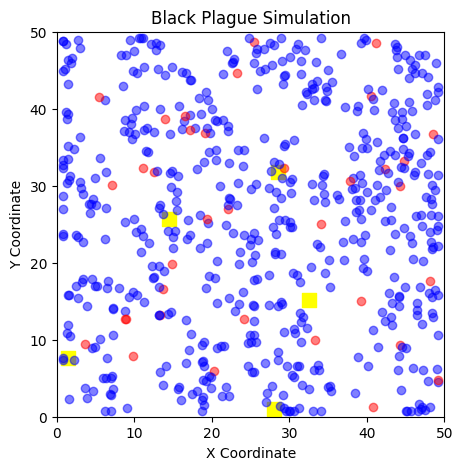

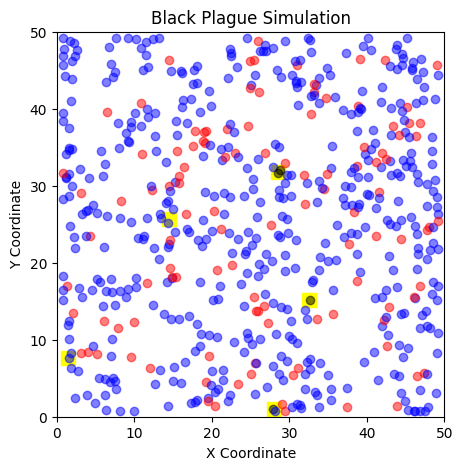

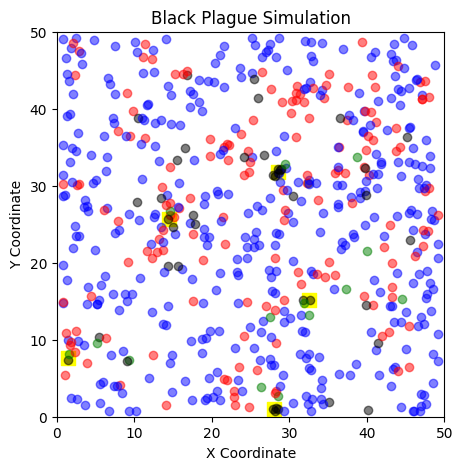

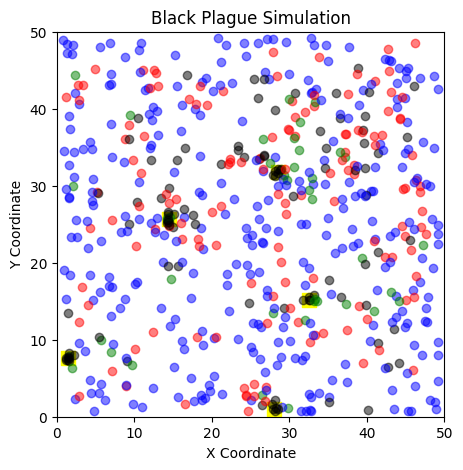

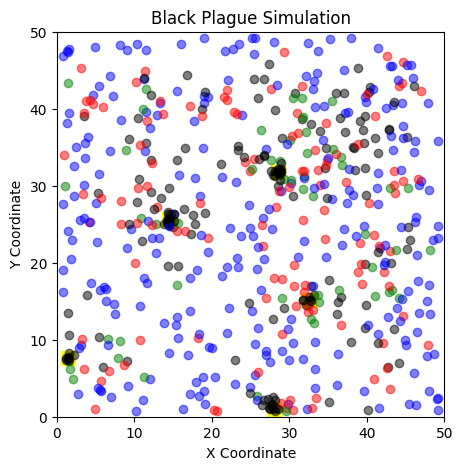

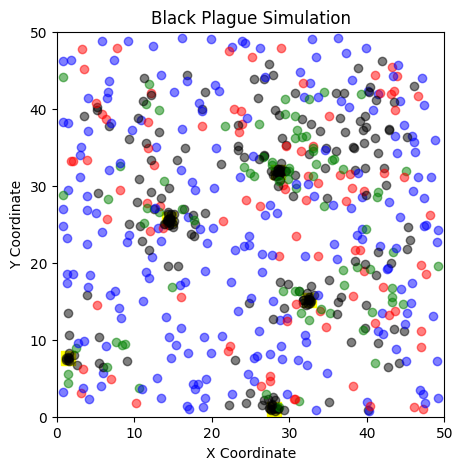

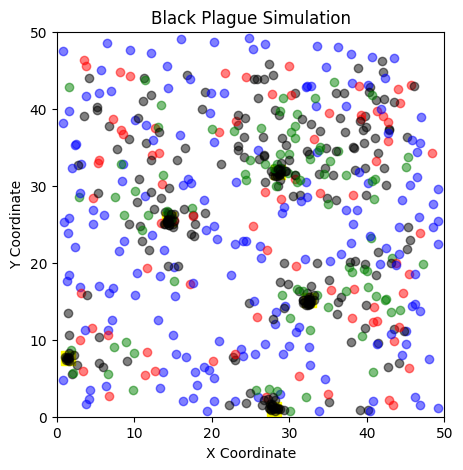

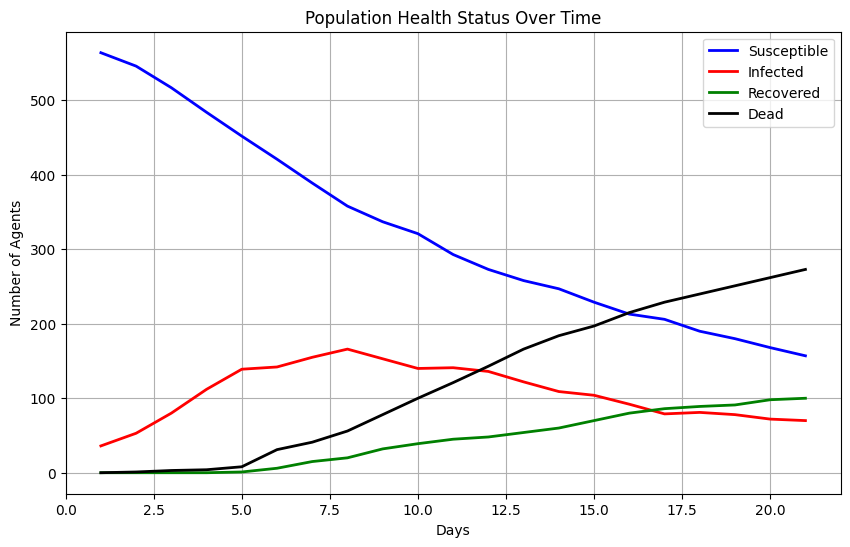

In [19]:
model = PlagueModel(width=50, height=50, num_agents=300, num_doctors=5)

for i in range(21):
  model.step()
  if i % 3 == 0: # shows each day for a week
    model.plot_agents()

model.plot_health_status_over_time()